In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay, classification_report

import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [29]:
ruta = '/content/drive/MyDrive/Colab_Notebooks/Diplomado_Ciencia-Datos-2025/Tema_6/FINAL/TEXTO'
os.chdir(ruta)
DataTrue =pd.read_csv('True.csv')  # Matríz de la expresión de genes}
DataFake = pd.read_csv('Fake.csv').squeeze("columns")  #Etiuetado, squeeze convierte el DataFrame en una serie para su manipulación

print(DataTrue.shape)
print(DataFake.shape)
#Son de tamaños similares.

(21417, 4)
(23481, 4)


In [30]:
DataTrue.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [31]:
DataFake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [32]:
DataTrue["subject"].value_counts()

,count
subject,
politicsNews,11272
worldnews,10145


In [33]:
DataFake["subject"].value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


Por ahora no me interesa tomar en cuenta las fechas en las que salieron las noticias, pues el análisis será puramente de texto y no de la correlación de noticias falsas con el tiempo.
Así que lo primero que haré será juntar las dos bases de datos (fake y true) en una que únicamente incluya título y texto. No incluiré la variable "subject" porque los valores en las bases no son los mismos y no quiero meter sesgos tratando de categorizarlos yo mismo.

En el nuevo Dataframe habrá una nueva columna "result". A las noticias en DataTrue se les asignará un valor True y a las noticias en DataFake se les asignará un valor False.

In [34]:
DataTrue["result"] = True
DataFake["result"] = False
df = pd.concat([DataTrue.drop(["subject","date"],axis=1),
                DataFake.drop(["subject","date"],axis=1)], ignore_index=True)
df.head()

,title,text,result
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,True


In [35]:
# Para dividir los datos entre entrenamiento y prueba los reordenaré de manera random con ayuda de numpy
np.random.seed(123)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True,inplace=True)

df.head()

,title,text,result
0,"ESPN SENIOR WRITER Says COPS, SOLDIERS Singing...",What happens when a black police officer sings...,False
1,Lawmaker says he misspoke about Republican Par...,WASHINGTON (Reuters) - Republican congressman ...,True
2,A**hole Of The Day – Michele Bachmann: Muslim...,Michele Bachmann has been pretty quiet since l...,False
3,New Book Reveals HILLARY’S ANTI-SEMITIC SIDE: ...,"Hillary doesn t recall saying it, but Bill s c...",False
4,CAN YOU GUESS THE ONE THING Majority Of Bernie...,The function of socialism is to raise sufferin...,False


In [36]:
#Guardamos df
df.to_csv('df.csv')

In [37]:
# Vamos a tokenizar las palabras, esto es, asignar un número a cada palabra de
# la base de datos.
# No pondré palabras máximas para que el tokenizador añada todas.

tokenizer = Tokenizer(oov_token="<OOV>")  # OOV para palabras desconocidas

tokenizer.fit_on_texts(df["title"])
tokenizer.fit_on_texts(df["text"])

In [38]:
diccionario = list(tokenizer.word_index)
print(diccionario[:10])
print("Se tienen ",len(diccionario),"palabras diferentes en el tokenizador")

['<OOV>', 'the', 'to', 'of', 'a', 'and', 'in', 'that', 's', 'on']
Se tienen  147709 palabras diferentes en el tokenizador


In [39]:
# Ya que tenemos un diccionario podemos convertir la base de datos a secuencias de números
df_sequences = df.copy()
df_sequences["title"] = tokenizer.texts_to_sequences(df_sequences["title"])
df_sequences["text"] = tokenizer.texts_to_sequences(df_sequences["text"])

In [40]:
df_sequences.head()

,title,text,result
0,"[5292, 429, 3530, 154, 1972, 1393, 5929, 28, 6...","[60, 1870, 62, 5, 223, 129, 776, 14244, 2, 131...",False
1,"[2008, 154, 15, 15346, 39, 80, 104, 2403]","[108, 70, 80, 1886, 903, 14428, 621, 4, 2, 69,...",True
2,"[5, 4725, 4, 2, 188, 1645, 9185, 11027, 307, 4...","[9185, 11027, 22, 45, 996, 4423, 140, 1207, 17...",False
3,"[61, 1183, 3760, 4279, 265, 5994, 768, 2058, 7...","[109, 433, 41, 4451, 193, 16, 33, 147, 9, 95, ...",False
4,"[78, 43, 2727, 2, 53, 428, 447, 4, 816, 349, 3...","[2, 3371, 4, 5194, 12, 3, 1351, 3065, 3, 5, 13...",False


In [41]:
# Padding: Aseguramos que todas las secuencias tengan la misma longitud
max_title = max(len(seq) for seq in df_sequences["title"])
max_text = max(len(seq) for seq in df_sequences["text"])
max_length = max(max_title,max_text)
print("La longitud máxima de las secuencias es: ",max_length)

df_sequences["title"]= pad_sequences(df_sequences["title"], maxlen=max_length, padding='post', truncating='post')
df_sequences["text"]= pad_sequences(df_sequences["text"], maxlen=max_length, padding='post', truncating='post')

La longitud máxima de las secuencias es:  8375


In [42]:
#Dividimos los datos en entrenamiento y prueba
X = df_sequences.drop("result", axis=1)
y = df_sequences["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Construcción del modelo de red neuronal con Embeddings y LSTM
model = Sequential([
    Embedding(input_dim=max_length, output_dim=64, input_length=max_length),  # Capa de embedding
    LSTM(64, return_sequences=True),  # Capa LSTM con salida en cada paso de tiempo

    LSTM(32),  # Segunda capa LSTM para extraer más información

    Dense(16, activation='relu'),  # Capa densa intermedia
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
])

In [44]:
# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Se utiliza Adam por combinar AdaGrad y RMSProp, es muy eficiente

In [45]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, verbose=1)

Epoch 1/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8799 - loss: 0.2520
Epoch 2/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9786 - loss: 0.0634
Epoch 3/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9849 - loss: 0.0454
Epoch 4/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9847 - loss: 0.0430
Epoch 5/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9871 - loss: 0.0367
Epoch 6/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9868 - loss: 0.0347
Epoch 7/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9873 - loss: 0.0349
Epoch 8/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9891 - loss: 0.0295
Epoch 9/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9871 - loss: 0.0346
Epoch 10/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9865 - loss: 0.0339
Epoch 11/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9875 - loss: 0.0322
Epoch 12/50
1123/1123 ━

In [46]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Pérdida en entrenamiento: {loss:.4f}")
print(f"Precisión en entrenamiento: {accuracy:.4f}")

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9905 - loss: 0.0236
Pérdida en entrenamiento: 0.0258
Precisión en entrenamiento: 0.9895


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


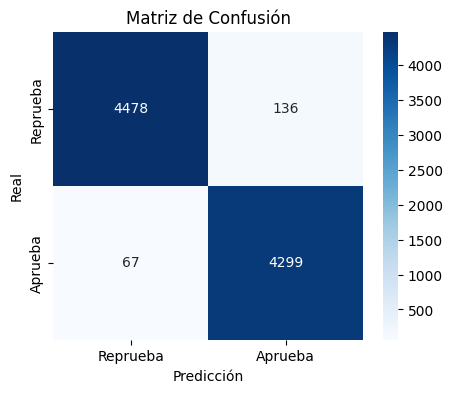

In [47]:
# UNA VEZ ENTRENADO EL MODELO SE USA EL CONJUNTO DE PRUEBA PARA LA MATRÍZ DE CONFUSIÓN

# Realizamos la predicción del modelo con el conjunto de prueba
# Convierte a la clase (0 o 1) usando un umbral de 0.5
y_pred_labels = (model.predict(X_test) >= 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test,y_pred_labels)

# Calculamos las métricas
accuracy = accuracy_score(y_test,y_pred_labels)
precision = precision_score(y_test,y_pred_labels)
recall = recall_score(y_test,y_pred_labels)
f1 = f1_score(y_test,y_pred_labels)
report = classification_report(y_test, y_pred_labels)

# Mostrar matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Reprueba", "Aprueba"], yticklabels=["Reprueba", "Aprueba"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [48]:
# Resultados
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9773942093541202
Precision: 0.9693348365276212
Recall: 0.9846541456710948
F1-score: 0.976934439268265
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.97      0.98      4614
        True       0.97      0.98      0.98      4366

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



## Resumen y Conclusiones

Se realizó un modelo de clasificación binaria para el análisis de Noticias.

Se utilizó una Red Neuronal Recurrente para tomar en cuenta la sintaxis y estructura del texto.

Se entrenó con 80% de los datos obteniendo precisión >90%.

Se demostró una precisión >90% para los datos de prueba (con los que no se entrenó el modelo).

Se observó de manera gráfica el desempeño de la red neuronal a través de una matríz de confusión.

Se concluye que, al menos en la base de datos tratada, es posible discriminar noticias falsas de las verdaderas a través de un modelo simple LSTM.

Las métricas del modelo confirman su alta confiabilidad.